/Users/vietbui/Documents/anaconda3/envs/ivy/lib/python3.11/site-packages/landlab/field/graph_field.py:1347: FutureWarning: Calling `add_empty` with the field location as the first argument is deprecated and will be removed in future versions. Instead, please use the `at` keyword to specify the location: add_empty(arg0, at='node').
  data = self.add_empty(*args, **kwds)


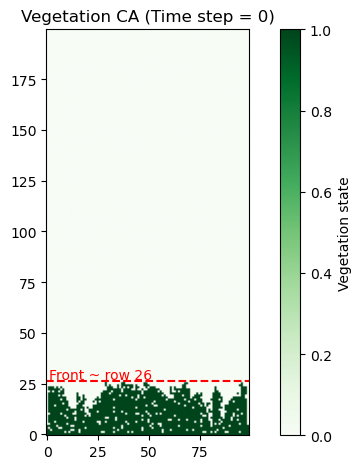

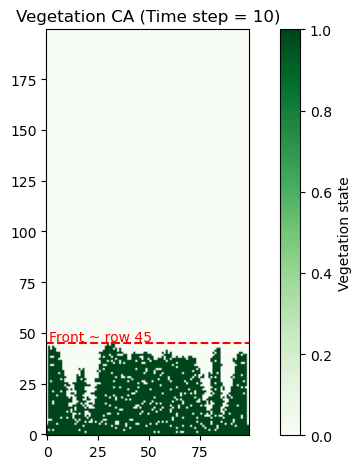

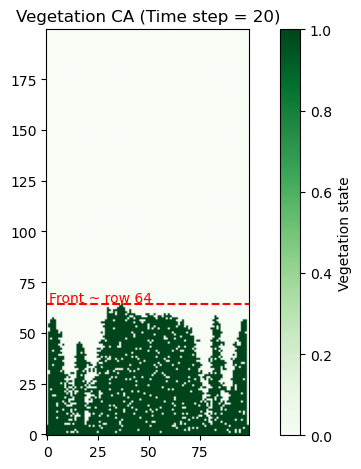

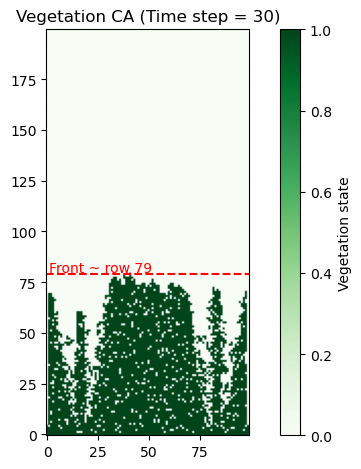

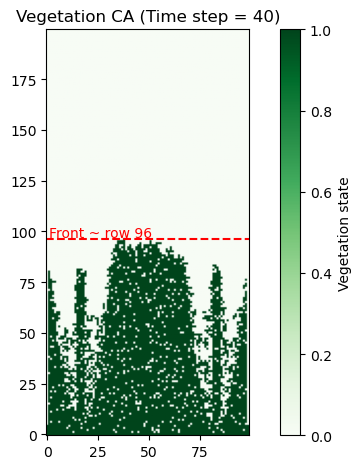

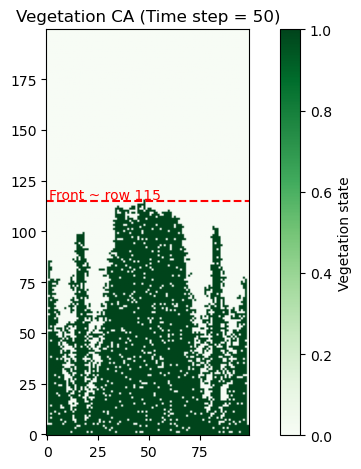

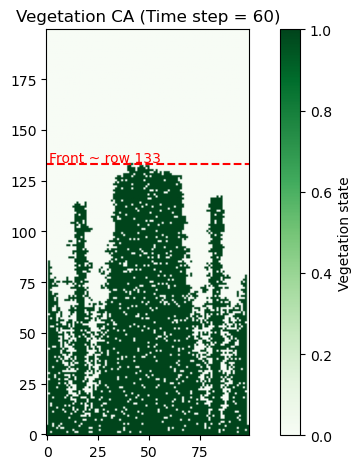

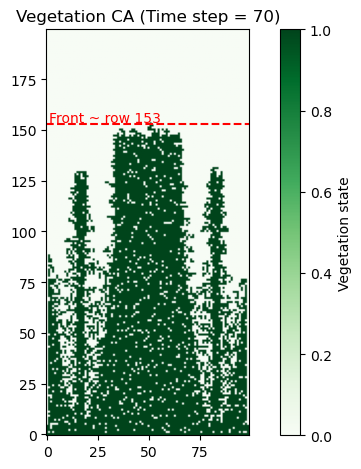

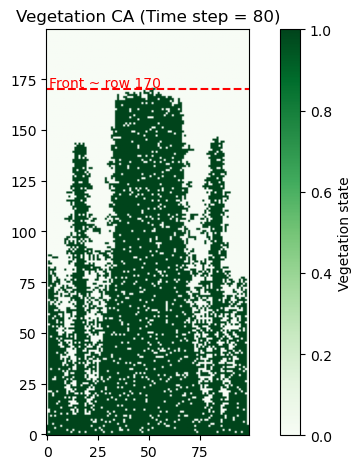

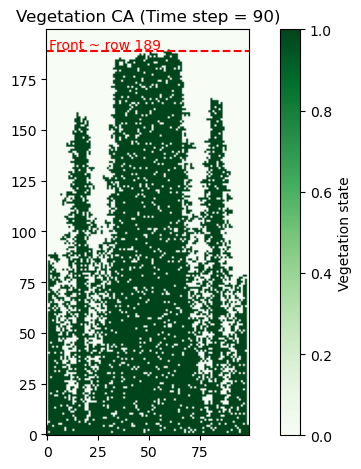

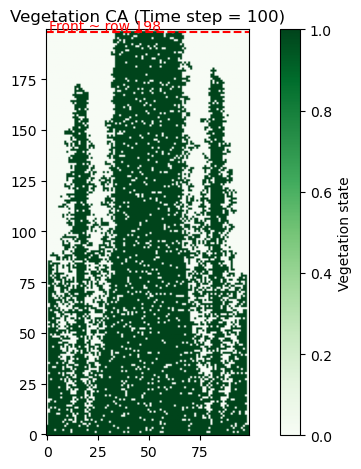

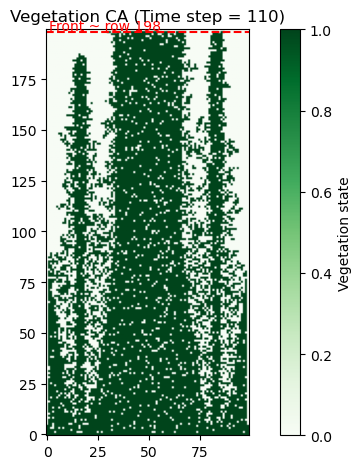

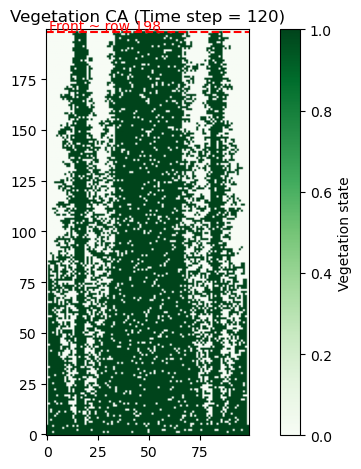

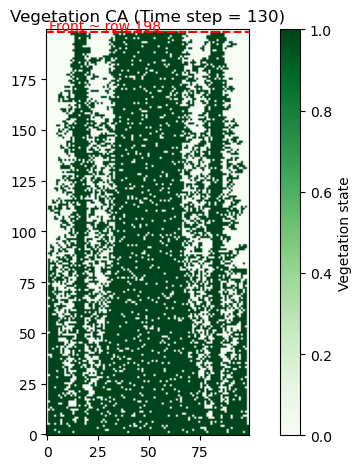

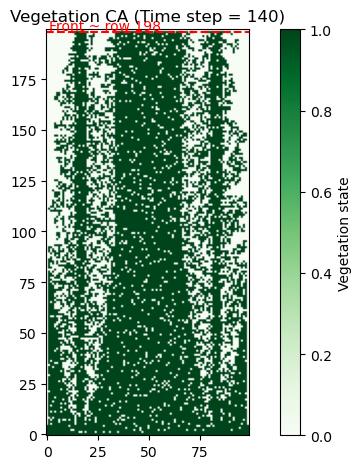

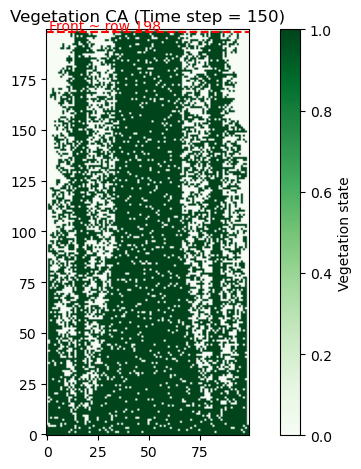

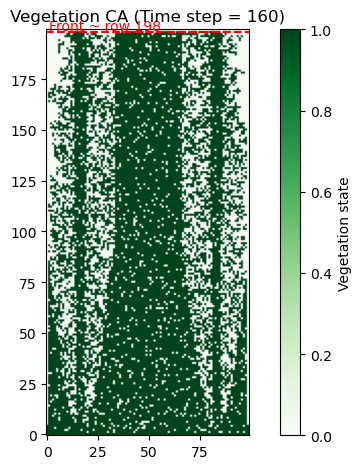

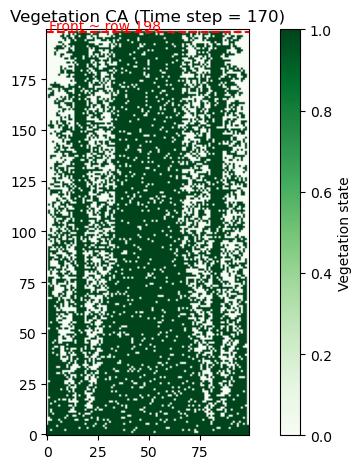

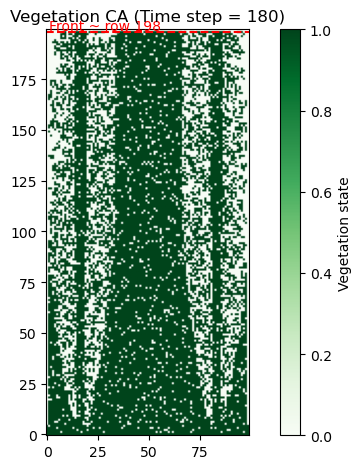

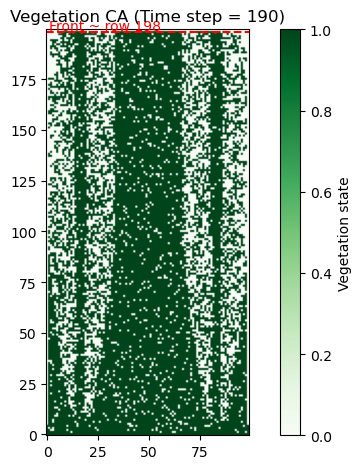

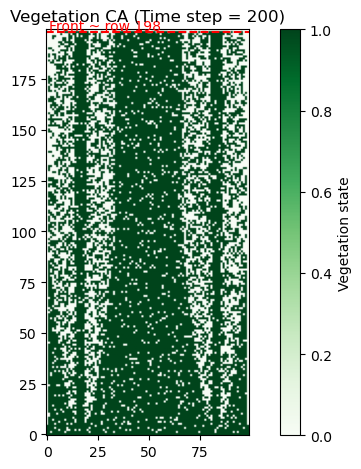

In [1]:
# packages for the model
from landlab.components import LinearDiffuser, OverlandFlow, FlowDirectorSteepest, FlowAccumulator, SedDepEroder
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid
from landlab.plot.graph import plot_graph
import matplotlib.pyplot as plt
from matplotlib import cm

#define the grid
size_x = 100
size_y = 200
spacing = 1.0
grid = RasterModelGrid((size_y, size_x), xy_spacing=spacing)

# morph the grid with a sine function
ice_height = 10
bedrock_slope = 0.22
soil_thickness = 5
moraine_disappears_at_y = 100

# k_sed = grid.add_ones("sediment_erodibility", at = "node")
# np.random.seed(seed=5000)




# break here for model topography
# add the topography    
z_ice = grid.add_zeros('ice_thickness', at='node')
z_soil = grid.add_zeros('soil_thickness', at='node')
z_bed = grid.add_zeros('bedrock_thickness', at='node')
elev = grid.add_zeros('topographic__elevation', at='node')

x = grid.x_of_node
y = grid.y_of_node

# setting ice elevation respected to the base elevation
z = ice_height * np.sin(np.pi*x / (size_x/3)) 
# get z where y is less than moraine_disappears_at_y
z[y < moraine_disappears_at_y] += (y[y < moraine_disappears_at_y] - moraine_disappears_at_y) * ice_height/moraine_disappears_at_y
z[z < 0] = 0 # cut the sine function at 0

z_ice += z
z_soil += soil_thickness
z_bed += bedrock_slope * y
elev = z_ice + z_soil + z_bed

"""
from landlab import RasterModelGrid
import pandas as pd
file_path = '../Kviarjokull_rotate_8_831m.csv'

# Read the CSV file
data = pd.read_csv(file_path, header=None)
spacing = 10.0 #meters
size_x = len(data.columns)
size_y = len(data.index)
grid = RasterModelGrid((size_y, size_x), xy_spacing=spacing)
elev = grid.add_zeros('topographic__elevation', at='node')
# Assign the elevation data to the grid
elev[:] = data.iloc[::-1, ::].values.flatten()


# add boundaries
grid.status_at_node[grid.nodes_at_left_edge] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[grid.nodes_at_right_edge] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[grid.nodes_at_top_edge] = grid.BC_NODE_IS_CLOSED

grid.imshow(elev)
"""


slope = np.rad2deg(grid.calc_slope_at_node(elevs=elev))  # For simplicity, you can use elevation directly for slope


# Instead of computing gradients, we'll simply modify the colonization rate based on elevation
def calc_colonization_rate(slope):
    """ Function to reduce colonization rate on higher slopes. """
    max_slope = 20  # Maximum slope (in degrees)
    if slope > max_slope:
        return 0.01  # Very low colonization on steep slopes
    else:
        return 0.1  # Normal colonization rate
        
    if grid_at.node["surface_water__depth"] < 0.1:
        return 0.1
    else: 
        return 0

# 2. Vegetation field (0 = bare, 1 = vegetated)
veg = grid.add_zeros('node', 'vegetation__state', dtype=int)
veg[grid.node_y < 5] = 1  # seed bottom 5 rows with vegetation

# Define erodibility values
def calc_erodibility(veg):
    """ Function to return erodibility based on vegetation state. """
    # High erodibility for non-vegetated cells and low erodibility for vegetated cells
    if veg == 1:
        return 0.005  # Lower erodibility for vegetated cells
    else:
        return 0.01  # Higher erodibility for non-vegetated cells

    

# 3. Parameters
d = 0.01  # disturbance probability
n_steps = 200

# 4. Define update function
def vegetation_ca_step(grid, veg, d, slope):
    new_veg = veg.copy()

    for node in grid.core_nodes:
        neighbors = grid.adjacent_nodes_at_node[node]
        if veg[node] == 0:
            # Calculate slope-based colonization rate
            # slope = np.rad2deg(grid.calc_slope_at_node(elevs=elev))  # For simplicity, you can use elevation directly for slope
            c = calc_colonization_rate(slope[node])
            
            # Colonization from neighbors
            if any(veg[n] == 1 for n in neighbors if n != -1):
                if np.random.rand() < c:
                    new_veg[node] = 1
        elif veg[node] == 1:
            # Disturbance/death
            if np.random.rand() < d:
                new_veg[node] = 0

    veg[:] = new_veg  # update in-place

# 5. Time loop with plot every 10 steps
for t in range(0, n_steps + 1, 10):
    for _ in range(100):
        vegetation_ca_step(grid, veg, d, slope)
    #hsd = grid.calc_hillshade_at_node(alt=45.0, az=315.0, slp=None, asp=None, unit='degrees', elevs='topographic__elevation')
    #plt.figure(figsize=(8, 6))
    #grid.imshow(hsd, cmap='gray')
    #plt.hold(True)
    plt.imshow(grid.node_vector_to_raster(veg), cmap='Greens', origin='lower')
    plt.title(f"Vegetation CA (Time step = {t})")
    plt.colorbar(label="Vegetation state")

    
    
    # Annotate front row
    raster = grid.node_vector_to_raster(veg)
    rows_with_veg = np.where(np.any(raster > 0, axis=1))[0]
    if len(rows_with_veg) > 0:
        front_row = rows_with_veg[-1]
        plt.axhline(front_row, color='red', linestyle='--')
        plt.text(1, front_row + 1, f"Front ~ row {front_row}", color='red')
    plt.tight_layout()
    plt.show()



In [11]:
print(veg)

[1 1 1 ... 0 0 0]


In [16]:
print(calc_erodibility)

<function calc_erodibility at 0x7822720967a0>


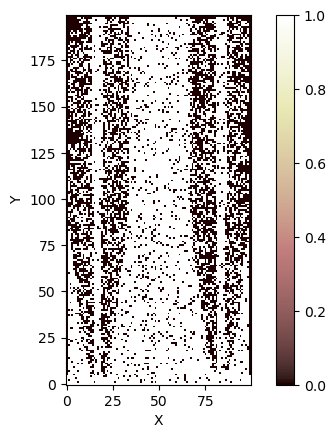

In [17]:
grid.imshow(veg)